In [3]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def construct_hamiltonian(N, M, V, mu, J, theta = 0, boundary_conditions = "OBC", chemical_potential_loc = 0):
    """Placeholder definition."""
    dim = M**N
    H = np.zeros((dim, dim), dtype=np.complex128)

    # Precompute powers of M for faster state-to-index conversion
    M_powers = np.array([M**i for i in range(N)])

    def index_to_state(index):
        return np.array([(index // M_powers[i]) % M for i in range(N-1, -1, -1)])
    
    # Helper function to convert a state representation (array of states) back to an index
    def state_to_index(state):
        return np.dot(state, M_powers[::-1])

    # Apply the chemical potential term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            if state[j] == chemical_potential_loc:
                H[alpha, alpha] -= mu
                    
    # Apply the tunneling term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            for n in range(M):
                if state[j] == n:
                    if n == 0:
                        if boundary_conditions == "PBC":
                            new_state = state.copy()
                            new_state[j] = M - 1
                            beta = state_to_index(new_state)
                            H[alpha, beta] -= J
                            H[beta, alpha] -= J
                        elif boundary_conditions == "OBC":
                            pass
                        
                    else:
                        new_state = state.copy()
                        new_state[j] = n - 1
                        beta = state_to_index(new_state)
                        
                        if n == 1:
                            H[alpha, beta] -= J*np.exp(1j*theta)
                            H[beta, alpha] -= J*np.exp(-1j*theta)
                            
                        else:
                            H[alpha, beta] -= J
                            H[beta, alpha] -= J  

    # Apply the interaction term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for i in range(N - 1):
            j = i + 1
            for n in range(M):
                if n == 0:
                    if boundary_conditions == "PBC":
                        if state[i] == 0 and state[j] == M - 1:
                            new_state = state.copy()
                            new_state[i], new_state[j] = M - 1, 0
                            beta = state_to_index(new_state)
                            H[alpha, beta] += V
                            H[beta, alpha] += V  
                    elif boundary_conditions == "OBC":
                        pass
                else:
                    if state[i] == n and state[j] == n - 1:
                        new_state = state.copy()
                        new_state[i], new_state[j] = n - 1, n
                        beta = state_to_index(new_state)
                        H[alpha, beta] += V
                        H[beta, alpha] += V  
        
    return H



In [ ]:
def new_construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio, theta = 0, boundary_conditions = "OBC", chemical_potential_loc = 0):
    """Placeholder definition."""
    mu = mu_V_ratio * abs(V)
    J = J_V_ratio * abs(V)

    H = construct_hamiltonian(N, M, V, mu, J, theta, boundary_conditions, chemical_potential_loc)
    H_tilde = H/np.abs(V)
    return H_tilde

In [4]:
def new_create_optimal_piecewise_linear_paths(N, M, T, dt, V, J_V_init, J_V_final, mu_V_init, mu_V_final, num_control_points, alpha = 2, initial_state = None, chemical_potential_loc = 0):
    
    # Dense time grid for evaluation.
    times_dense = np.arange(0, T + dt, dt)
    
    # Number of control points and free (intermediate) points.
    n_points = num_control_points
    n_int = n_points - 2

    # Initial guesses for the control values (linearly spaced between endpoints).
    J_initial_guess = np.linspace(J_V_init, J_V_final, n_points)[1:-1]
    mu_initial_guess = np.linspace(mu_V_init, mu_V_final, n_points)[1:-1]
    
    # Non-linear initial guess for intermediate times: more time allocated toward the end.
    t_initial_guess = T * (np.linspace(0, 1, n_points)[1:-1] ** alpha)

    # Combine intermediate control values and times into one vector.
    x0 = np.concatenate((J_initial_guess, mu_initial_guess, t_initial_guess))
    
    # A small buffer to ensure strict ordering of times.
    eps = 1e-3

    # Constraints for the intermediate times: they must be strictly between 0 and T and in ascending order.
    cons = []
    cons.append({'type': 'ineq', 'fun': lambda x: x[2*n_int] - eps})
    for i in range(1, n_int):
        cons.append({
            'type': 'ineq',
            'fun': lambda x, i=i: x[2*n_int + i] - x[2*n_int + i - 1] - eps
        })
    cons.append({'type': 'ineq', 'fun': lambda x: T - x[2*n_int + n_int - 1] - eps})
    
    # Weights for the penalty terms.
    lambda_adiabatic = 0.25       
    lambda_smooth_J = 0.1 
    lambda_smooth_mu = 0.1
    
    def objective(x):
        # Unpack the optimization vector.
        J_int = x[:n_int]
        mu_int = x[n_int:2*n_int]
        t_int = x[2*n_int:3*n_int]
        
        # Reconstruct full control arrays including fixed endpoints.
        J_control = np.concatenate(([J_V_init], J_int, [J_V_final]))
        mu_control = np.concatenate(([mu_V_init], mu_int, [mu_V_final]))
        t_control = np.concatenate(([0.0], t_int, [T]))
        
        # Build dense paths using linear interpolation.
        J_path_dense = np.interp(times_dense, t_control, J_control)
        mu_path_dense = np.interp(times_dense, t_control, mu_control)
        
        # Penalty for any negative μ/|V| values.
        penalty = np.sum(np.abs(np.minimum(0, mu_path_dense)))
        
        # Smoothness penalty using discrete second differences.
        smoothness_penalty_J = lambda_smooth_J * np.sum(np.diff(J_control, 2)**2)
        smoothness_penalty_mu = lambda_smooth_mu * np.sum(np.diff(mu_control, 2)**2)
        smoothness_penalty = smoothness_penalty_J + smoothness_penalty_mu
        
        # Construct Hamiltonians at each point in the dense time grid.
        hamiltonians = []
        for i, t in enumerate(times_dense):
            ham = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio=mu_path_dense[i], J_V_ratio=J_path_dense[i], chemical_potential_loc = chemical_potential_loc)
            hamiltonians.append(ham)
        
        # Adiabaticity penalty: discourages rapid changes in the Hamiltonian.
        adiabatic_penalty = 0.0
        for i in range(len(times_dense) - 1):
            # Finite difference approximation for the derivative of the control parameters.
            dJ = J_path_dense[i+1] - J_path_dense[i]
            dmu = mu_path_dense[i+1] - mu_path_dense[i]
            dH_norm = np.sqrt(dJ**2 + dmu**2)
            # Compute the energy gap using the instantaneous Hamiltonian.
            energies, _ = exact_diagonalize(hamiltonians[i])
            gap = energies[1] - energies[0]
            adiabatic_penalty += (dH_norm**2 / gap**2) * (times_dense[i+1] - times_dense[i])
        adiabatic_penalty *= lambda_adiabatic
        
        # Simulate the time evolution and compute the ground state infidelity.
        _, _, _, _, _, calculate_ground_state_manifold_overlaps = simulate_hamiltonian_time_evolution(hamiltonians, times_dense, initial_state = initial_state)
        ground_state_fidelity = calculate_ground_state_manifold_overlaps[-1]
        ground_state_infidelity = 1 - ground_state_fidelity
        
        return ground_state_infidelity + penalty + smoothness_penalty + adiabatic_penalty

    # Optimize the control parameters using SLSQP to enforce the constraints.
    result = minimize(objective, x0, method='SLSQP', constraints=cons)
    opt_params = result.x

    # Extract the optimized intermediate values.
    J_int_opt = opt_params[:n_int]
    mu_int_opt = opt_params[n_int:2*n_int]
    t_int_opt = opt_params[2*n_int:3*n_int]

    # Construct full control arrays including endpoints.
    J_control_opt = np.concatenate(([J_V_init], J_int_opt, [J_V_final]))
    mu_control_opt = np.concatenate(([mu_V_init], mu_int_opt, [mu_V_final]))
    t_control_opt = np.concatenate(([0.0], t_int_opt, [T]))

    # Generate the optimized dense paths.
    J_V_path = np.interp(times_dense, t_control_opt, J_control_opt)
    mu_V_path = np.interp(times_dense, t_control_opt, mu_control_opt)
    
    obj_value = result.fun
    return (times_dense, J_V_path, mu_V_path, obj_value, opt_params, t_control_opt, J_control_opt, mu_control_opt)


In [5]:
import numpy as np

# Parameters
J_V_init = 0
J_V_final = 0.5

mu_V_init = 10
mu_V_final = 0

n_points = 10
T = 10
alpha = 4

# Non-linear spacing in time (bunched near the end)
s = np.linspace(0, 1, n_points)[1:-1]  # exclude endpoints
s_nonlinear = 1 - (1 - s) ** alpha  # bunch near end

# Apply nonlinear spacing to J and mu
J_initial_guess = J_V_init + s_nonlinear * (J_V_final - J_V_init)
mu_initial_guess = mu_V_init + s_nonlinear * (mu_V_final - mu_V_init)

# Optional: corresponding nonlinear times
t_initial_guess = T * s_nonlinear

# Output
print("t =", t_initial_guess)
print("J =", J_initial_guess)
print("mu =", mu_initial_guess)


t = [3.75704923 6.34049688 8.02469136 9.04740131 9.60981558 9.87654321
 9.97561347 9.99847584]
J = [0.18785246 0.31702484 0.40123457 0.45237007 0.48049078 0.49382716
 0.49878067 0.49992379]
mu = [6.24295077e+00 3.65950312e+00 1.97530864e+00 9.52598689e-01
 3.90184423e-01 1.23456790e-01 2.43865264e-02 1.52415790e-03]


(-10.0, 10.0)

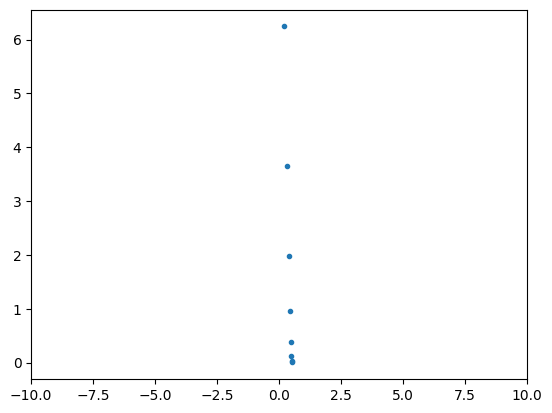

In [6]:
fig, ax = plt.subplots()
ax.plot(J_initial_guess, mu_initial_guess, '.')
ax.set_xlim(-10,10)

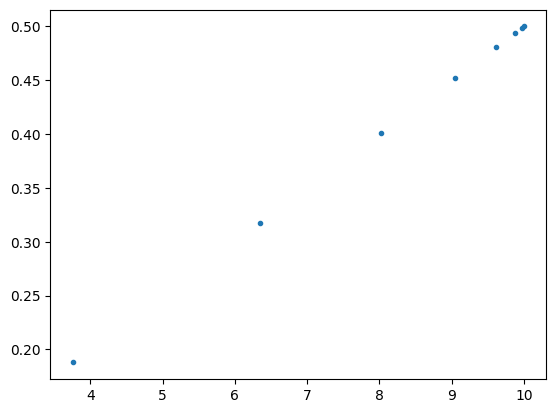

In [7]:
fig, ax = plt.subplots()
ax.plot(t_initial_guess, J_initial_guess, '.')